In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


/Users/leo/MasterDegree/Courses/DL/dl_env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/leo/MasterDegree/Courses/DL/dl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(train_data, test_data), info = tfds.load('mnist',
                                      split=['train', 'test'],
                                      shuffle_files=True,
                                      as_supervised=True,
                                      with_info=True)


In [3]:
BATCH_SIZE = 128


def parse_fn(image, label):
    x = tf.cast(image, tf.float32) / 255.
    y = label
    return x, y


train_data = train_data.shuffle(info.splits['train'].num_examples)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.prefetch(tf.data.AUTOTUNE)

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.prefetch(tf.data.AUTOTUNE)


In [4]:
# L2_REG = 1e-4
L2_REG = 0

KERNEL_SIZE = 3
STRIDE_SIZE = 1

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=info.features['image'].shape),  # type: ignore
    tf.keras.layers.Conv2D(filters=8,
                           kernel_size=KERNEL_SIZE,
                           strides=STRIDE_SIZE,
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.Conv2D(filters=4,
                           kernel_size=KERNEL_SIZE,
                           strides=STRIDE_SIZE,
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [5]:
import os

logdir = os.path.join(
    'logs',
    'mnist',
    f'filter_{KERNEL_SIZE}_stride_{STRIDE_SIZE}_l2_{L2_REG}',
)
os.makedirs(logdir, exist_ok=True)

In [6]:
with open(os.path.join(logdir, 'model.json'), 'w', encoding='utf-8') as f:
    print(model.to_json(), file=f)


def log_summary(string):
    print(string)
    with open(os.path.join(logdir, 'summary.txt'), 'a', encoding='utf-8') as f:
        print(string, file=f)


model.summary(print_fn=log_summary)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 4)         292       
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 10)                23050     
                                                                 
Total params: 23422 (91.49 KB)
Trainable params: 23422 (91.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_graph=True,
)

model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    callbacks=[tensorboard_callback],
)


Epoch 1/10
469/469 [==============================] - 5s 8ms/step - loss: 0.3944 - sparse_categorical_accuracy: 0.8905 - val_loss: 0.2113 - val_sparse_categorical_accuracy: 0.9377
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.1308 - val_sparse_categorical_accuracy: 0.9611
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.1002 - val_sparse_categorical_accuracy: 0.9700
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.0801 - val_sparse_categorical_accuracy: 0.9753
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0725 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0696 - val_sparse_categorical_accuracy: 0.9777
Epoch 6/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0611 - sparse_categor

pred: 2, label: 2


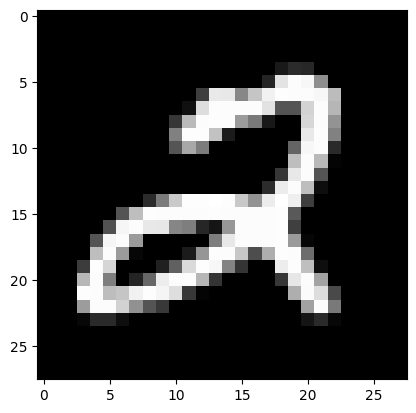

In [11]:
import matplotlib.pyplot as plt

for data, label in test_data.unbatch():
    preds = model(data[tf.newaxis, ...])[0]
    pred = tf.argmax(preds).numpy()
    label = label.numpy()

    if pred == label:
        print(f'pred: {pred}, label: {label}')
        plt.imshow(data.numpy(), cmap='gray')
        break



pred: 2, label: 7


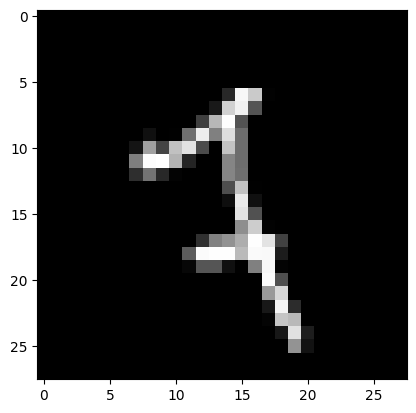

In [12]:
for data, label in test_data.unbatch():
    preds = model(data[tf.newaxis, ...])[0]
    pred = tf.argmax(preds).numpy()
    label = label.numpy()

    if pred != label:
        print(f'pred: {pred}, label: {label}')
        plt.imshow(data.numpy(), cmap='gray')
        break

6
conv2d
(1, 26, 26, 8)


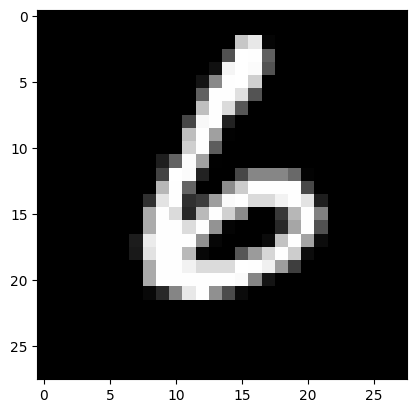

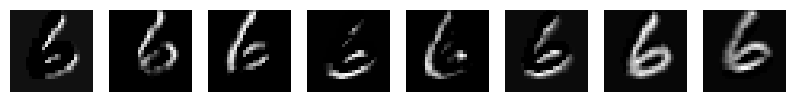

conv2d_1
(1, 24, 24, 4)


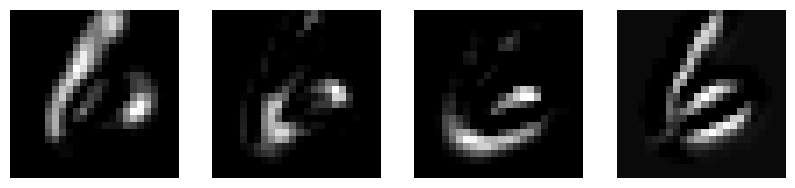

In [10]:
sample_data, sample_label = next(iter(train_data.unbatch().take(1)))
sample_data = sample_data[tf.newaxis, ...]
plt.imshow(sample_data.numpy().squeeze(), cmap='gray')
print(sample_label.numpy())

features = {}
for layer in model.layers:
    sample_data = layer(sample_data)
    if 'conv2d' in layer.name:
        features.update({layer.name: sample_data})

for name, feature in features.items():
    print(name)
    print(feature.shape)

    figure = plt.figure(figsize=(10, 10))
    for i in range(feature.shape[-1]):
        ax = figure.add_subplot(1, feature.shape[-1], i + 1)
        ax.imshow(feature[0, :, :, i].numpy(), cmap='gray')
        ax.axis('off')
    plt.show()
